In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import heapq
from datetime import datetime
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
from collections import Counter
import random

In [2]:
def most_frequent(array):
    # Count the occurrences of each element in the array
    counter = Counter(array)
    
    # Get the most common element and its count
    most_common = counter.most_common(1)
    
    # Return the most common element
    return most_common[0][0]

In [3]:
class SVM_cvxopt:
    
    def __init__(self, training_images, training_labels):

        self.training_images = training_images
        self.training_labels = training_labels
        
        self.X_train = None
        self.Y_train = None
        
        #cvxopt inputs
        self.P = None
        self.q = None
        self.G = None
        self.h = None
        self.A = None
        self.b = None
        
        #cvxopt outputs
        self.sol = None
        
        #Number of training examples
        self.m = len(training_images)
        
        #Parameters
        self.alpha = None
        self.w = None
        self.bias = None
        
        #Support vectors
        self.n_support_ = None
        self.support_ = None
    
    @staticmethod
    def resize_and_flatten(img_path, size):
        # Load the image
        image = cv2.imread(img_path)

        # Resize the image
        resized_image = cv2.resize(image, (size, size))

        # Flatten the resized image
        flattened_vector = resized_image.flatten()/255.0

        return flattened_vector
    
    @staticmethod
    def top_indexes(arr, n):
        return [idx for idx, val in heapq.nlargest(n, enumerate(arr), key=lambda x: x[1])]
    
    @staticmethod
    def flatten_to_img(X, size):
        shape = (size,size,3)
        img = (X).reshape(shape)
        return img
    
    @staticmethod
    def get_matrix_form(images, labels, size):
        #takes the list of images and labels and returns X, Y
        X_mat = []
        Y_vec = []
        for i in range(len(images)):
            X_mat.append(SVM_cvxopt.resize_and_flatten(images[i], size))
            Y_vec.append([labels[i]])

        X = np.array(X_mat)
        Y = np.array(Y_vec)
        
        return X,Y
    
    def set_X_train_Y_train(self):
        #specifically creates the X_train and Y_train matrix
        self.X_train, self.Y_train = SVM_cvxopt.get_matrix_form(self.training_images, self.training_labels, 16)
    
    @staticmethod
    def linear_kernel(X):
        return np.matmul(X, X.T)
    
    def cvxopt_solver(self):
        #sets the cvxopt inputs and invoke the solver
        #P
        P_x = SVM_cvxopt.linear_kernel(self.X_train)
        P_y = np.matmul(self.Y_train, self.Y_train.T)
        self.P = matrix(np.multiply(P_x, P_y).astype('float'))
        
        #q
        self.q = matrix(-1*np.ones((self.m,1)).astype('float'))
        
        #G
        G_u = np.zeros((self.m, self.m))
        np.fill_diagonal(G_u, -1)
        G_d = np.zeros((self.m, self.m))
        np.fill_diagonal(G_d, 1)
        self.G = matrix(np.concatenate((G_u, G_d), axis=0).astype('float'))
        
        #h
        h_u = np.zeros((self.m,1))
        h_d = np.ones((self.m,1))
        self.h = matrix(np.concatenate((h_u,h_d), axis=0).astype('float'))
        
        #A
        self.A = matrix(self.Y_train.T.astype('float'))
        
        #b
        self.b = matrix(np.zeros(1).astype('float'))
        
        # Construct the QP, invoke solver
        self.sol = solvers.qp(self.P, self.q, self.G, self.h, self.A, self.b)
        
    def set_params(self):
        #sets the alpha, w and b
        #alpha
        self.alpha = np.array(self.sol['x'])
        
        #w
        w = self.alpha[0][0] * self.Y_train[0][0] * self.X_train[0]
        for i in range(1, self.m):
            w += self.alpha[i][0] * self.Y_train[i][0] * self.X_train[i]
        self.w = w.reshape(len(self.X_train[0]),1)
        
        #b
        min_b = float('inf')
        max_b = float('-inf')
        for i in range(self.m):
            temp = np.matmul(self.w.T, self.X_train[i])[0]
            if self.Y_train[i][0] == -1:
                if temp > max_b:
                    max_b = temp
            elif self.Y_train[i][0] == 1:
                if temp < min_b:
                    min_b = temp
        self.bias = -(min_b + max_b)/2
        
    def count_nSv(self):
        #prints the number of support vectors
        epsilon = 0.0001
        count = np.count_nonzero(np.abs(self.alpha - 0) >= epsilon)
        self.n_support_ = count
        print("Number of support vectors: ", count)
        print("Percentage of support vectors: ", count*100/self.X_train.shape[0])
        
    def store_support_(self):
        epsilon = 0.0001
        mask = np.abs(self.alpha - 0) >= epsilon
        self.support_ = np.where(mask == 1)[0]
        
    def plot_top_6_images(self, size):
        #plots the top 6 coefficient support vectors
        idx = SVM_cvxopt.top_indexes(self.alpha, 6)
        fig, axs = plt.subplots(2,3,figsize=(15,10)) # 2 rows, 3 per row, 15x10 size to each image 

        img1 = SVM_cvxopt.flatten_to_img(self.X_train[idx[0]],size)
        img2 = SVM_cvxopt.flatten_to_img(self.X_train[idx[1]],size)
        img3 = SVM_cvxopt.flatten_to_img(self.X_train[idx[2]],size)
        img4 = SVM_cvxopt.flatten_to_img(self.X_train[idx[3]],size)
        img5 = SVM_cvxopt.flatten_to_img(self.X_train[idx[4]],size)
        img6 = SVM_cvxopt.flatten_to_img(self.X_train[idx[5]],size)

        # Top row
        axs[0, 0].imshow(img1) # Place img1 at position (0,0)
        axs[0, 1].imshow(img2) # Place img2 at position (0,1)
        axs[0, 2].imshow(img3) # Place img3 at position (0,2)

        # Bottom row
        axs[1, 0].imshow(img4) # Place img4 at position (1,0)
        axs[1, 1].imshow(img5) # Place img5 at position (1,1)
        axs[1, 2].imshow(img6) # Place img6 at position (1,2)

        #To hide x, y tick values
        for row in axs:
            for ax in row:
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)

        plt.show()
        
    def plot_top_6_images_actual(self, size):
        #plots the top 6 coefficient support vectors
        idx = SVM_cvxopt_rbf.top_indexes(self.alpha, 6)
        fig, axs = plt.subplots(2,3,figsize=(15,10)) # 2 rows, 3 per row, 15x10 size to each image 

        img1 = cv2.imread(self.training_images[idx[0]])
        img2 = cv2.imread(self.training_images[idx[1]])
        img3 = cv2.imread(self.training_images[idx[2]])
        img4 = cv2.imread(self.training_images[idx[3]])
        img5 = cv2.imread(self.training_images[idx[4]])
        img6 = cv2.imread(self.training_images[idx[5]])

        # Top row
        axs[0, 0].imshow(img1) # Place img1 at position (0,0)
        axs[0, 1].imshow(img2) # Place img2 at position (0,1)
        axs[0, 2].imshow(img3) # Place img3 at position (0,2)

        # Bottom row
        axs[1, 0].imshow(img4) # Place img4 at position (1,0)
        axs[1, 1].imshow(img5) # Place img5 at position (1,1)
        axs[1, 2].imshow(img6) # Place img6 at position (1,2)

        #To hide x, y tick values
        for row in axs:
            for ax in row:
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)

        plt.show()
        
    def plot_w(self, size):
        #plot w
        img = SVM_cvxopt.flatten_to_img(self.w, size)
        plt.imshow(img)
        plt.show()
        
    def execute(self):
        self.set_X_train_Y_train()
        self.cvxopt_solver()
        self.set_params()
        self.count_nSv()
        self.store_support_()
        self.plot_top_6_images(16)
        self.plot_top_6_images_actual(16)
        self.plot_w(16)
        
    def test(self, testing_images, testing_labels):
        X_test, Y_test = SVM_cvxopt.get_matrix_form(testing_images, testing_labels, 16)
        Y_test_pred = np.zeros((len(testing_images),1))
        for i in range(X_test.shape[0]):
            temp = np.matmul(self.w.T, X_test[i]) + self.bias
            if temp <= 0:
                Y_test_pred[i][0] = -1
            else:
                Y_test_pred[i][0] = 1
        
        #Accuracy
        accuracy = 0
        for i in range(Y_test.shape[0]):
            if Y_test[i] == Y_test_pred[i]:
                accuracy += 1

        print("Accuracy = ", accuracy*100.0/Y_test.shape[0])
        
        return Y_test_pred

In [4]:
class SVM_cvxopt_rbf:
    
    def __init__(self, training_images, training_labels):

        self.training_images = training_images
        self.training_labels = training_labels
        
        self.X_train = None
        self.Y_train = None
        
        #cvxopt inputs
        self.P = None
        self.q = None
        self.G = None
        self.h = None
        self.A = None
        self.b = None
        
        #cvxopt outputs
        self.sol = None
        
        #Number of training examples
        self.m = len(training_images)
        
        #Parameters
        self.alpha = None
        # self.w = None
        self.bias = None
        
        #Support vectors
        self.n_support_ = None
        self.support_ = None
        self.X_sv = None
        self.K = None
        self.sv_y = None
        self.alpha_sv = None
    
    @staticmethod
    def resize_and_flatten(img_path, size):
        # Load the image
        image = cv2.imread(img_path)

        # Resize the image
        resized_image = cv2.resize(image, (size, size))

        # Flatten the resized image
        flattened_vector = resized_image.flatten()/255.0

        return flattened_vector
    
    @staticmethod
    def top_indexes(arr, n):
        return [idx for idx, val in heapq.nlargest(n, enumerate(arr), key=lambda x: x[1])]
    
    @staticmethod
    def flatten_to_img(X, size):
        shape = (size,size,3)
        img = (X).reshape(shape)
        return img
    
    @staticmethod
    def get_matrix_form(images, labels, size):
        #takes the list of images and labels and returns X, Y
        X_mat = []
        Y_vec = []
        for i in range(len(images)):
            X_mat.append(SVM_cvxopt_rbf.resize_and_flatten(images[i], size))
            Y_vec.append([labels[i]])

        X = np.array(X_mat)
        Y = np.array(Y_vec)
        
        return X,Y
    
    def set_X_train_Y_train(self):
        #specifically creates the X_train and Y_train matrix
        self.X_train, self.Y_train = SVM_cvxopt_rbf.get_matrix_form(self.training_images, self.training_labels, 16)

    @staticmethod
    def rbf_kernel(X_i, X_j, gamma=0.001):
        return np.exp(-gamma * np.linalg.norm(X_i - X_j) ** 2)
    
    @staticmethod
    def rbf_kernel_matrix(X, gamma=0.001):
        # Number of samples
        n_samples = X.shape[0]

        # Initialize K with zeros
        K = np.zeros((n_samples, n_samples))

        # Compute the Gram matrix
        for i in range(n_samples):
            for j in range(n_samples):
                if i <= j:
                    K[i, j] = np.exp(-gamma * np.linalg.norm(X[i] - X[j]) ** 2)
                    K[j, i] = K[i, j]
        return K
    
    @staticmethod
    def rbf_kernel_matrix_fast(X, gamma=0.001):
        K = rbf_kernel(X, gamma=0.001)
        return K
    
    def cvxopt_solver(self):
        #sets the cvxopt inputs and invoke the solver
        #P
        P_x = SVM_cvxopt_rbf.rbf_kernel_matrix_fast(self.X_train)
        P_y = np.matmul(self.Y_train, self.Y_train.T)
        self.P = matrix(np.multiply(P_x, P_y).astype('float'))
        
        #q
        self.q = matrix(-1*np.ones((self.m,1)).astype('float'))
        
        #G
        G_u = np.zeros((self.m, self.m))
        np.fill_diagonal(G_u, -1)
        G_d = np.zeros((self.m, self.m))
        np.fill_diagonal(G_d, 1)
        self.G = matrix(np.concatenate((G_u, G_d), axis=0).astype('float'))
        
        #h
        h_u = np.zeros((self.m,1))
        h_d = np.ones((self.m,1))
        self.h = matrix(np.concatenate((h_u,h_d), axis=0).astype('float'))
        
        #A
        self.A = matrix(self.Y_train.T.astype('float'))
        
        #b
        self.b = matrix(np.zeros(1).astype('float'))
        
        # Construct the QP, invoke solver
        self.sol = solvers.qp(self.P, self.q, self.G, self.h, self.A, self.b)
        
    def set_params(self):
        #sets the alpha, w and b
        #alpha
        self.alpha = np.array(self.sol['x'])
        
        #support_
        epsilon = 0.0001
        mask = np.abs(self.alpha - 0) >= epsilon
        self.support_ = np.where(mask == 1)[0]
        
        #alpha_sv
        self.alpha_sv = self.alpha[mask.ravel()]
        
        #n_support_
        count = np.count_nonzero(np.abs(self.alpha - 0) >= epsilon)
        self.n_support_ = count
        
        #sv_y
        self.sv_y = np.array([self.Y_train[idx] for idx in self.support_]).reshape(self.n_support_,1)
        
        #bias
        self.X_sv = self.X_train[mask.ravel()]
        self.K = SVM_cvxopt_rbf.rbf_kernel_matrix_fast(self.X_sv)
        self.bias = 0
        for i in range(len(self.alpha_sv)):
            self.bias += self.sv_y[i][0]
            self.bias -= np.sum(self.alpha_sv * self.sv_y * self.K[i].reshape(self.n_support_,1))
        self.bias /= len(self.alpha_sv)
        
    def plot_top_6_images(self, size):
        #plots the top 6 coefficient support vectors
        idx = SVM_cvxopt_rbf.top_indexes(self.alpha, 6)
        fig, axs = plt.subplots(2,3,figsize=(15,10)) # 2 rows, 3 per row, 15x10 size to each image 

        img1 = SVM_cvxopt_rbf.flatten_to_img(self.X_train[idx[0]],size)
        img2 = SVM_cvxopt_rbf.flatten_to_img(self.X_train[idx[1]],size)
        img3 = SVM_cvxopt_rbf.flatten_to_img(self.X_train[idx[2]],size)
        img4 = SVM_cvxopt_rbf.flatten_to_img(self.X_train[idx[3]],size)
        img5 = SVM_cvxopt_rbf.flatten_to_img(self.X_train[idx[4]],size)
        img6 = SVM_cvxopt_rbf.flatten_to_img(self.X_train[idx[5]],size)

        # Top row
        axs[0, 0].imshow(img1) # Place img1 at position (0,0)
        axs[0, 1].imshow(img2) # Place img2 at position (0,1)
        axs[0, 2].imshow(img3) # Place img3 at position (0,2)

        # Bottom row
        axs[1, 0].imshow(img4) # Place img4 at position (1,0)
        axs[1, 1].imshow(img5) # Place img5 at position (1,1)
        axs[1, 2].imshow(img6) # Place img6 at position (1,2)

        #To hide x, y tick values
        for row in axs:
            for ax in row:
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)

        plt.show()
        
    def plot_top_6_images_actual(self, size):
        #plots the top 6 coefficient support vectors
        idx = SVM_cvxopt_rbf.top_indexes(self.alpha, 6)
        fig, axs = plt.subplots(2,3,figsize=(15,10)) # 2 rows, 3 per row, 15x10 size to each image 

        img1 = cv2.imread(self.training_images[idx[0]])
        img2 = cv2.imread(self.training_images[idx[1]])
        img3 = cv2.imread(self.training_images[idx[2]])
        img4 = cv2.imread(self.training_images[idx[3]])
        img5 = cv2.imread(self.training_images[idx[4]])
        img6 = cv2.imread(self.training_images[idx[5]])

        # Top row
        axs[0, 0].imshow(img1) # Place img1 at position (0,0)
        axs[0, 1].imshow(img2) # Place img2 at position (0,1)
        axs[0, 2].imshow(img3) # Place img3 at position (0,2)

        # Bottom row
        axs[1, 0].imshow(img4) # Place img4 at position (1,0)
        axs[1, 1].imshow(img5) # Place img5 at position (1,1)
        axs[1, 2].imshow(img6) # Place img6 at position (1,2)

        #To hide x, y tick values
        for row in axs:
            for ax in row:
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)

        plt.show()
        
    def execute(self):
        self.set_X_train_Y_train()
        self.cvxopt_solver()
        self.set_params()
        #self.plot_top_6_images(16)
        #self.plot_top_6_images_actual(16)
        
    def test(self, testing_images, testing_labels):
        X_test, Y_test = SVM_cvxopt.get_matrix_form(testing_images, testing_labels, 16)
        Y_test_pred = np.zeros((len(testing_images),1))
        for i in range(X_test.shape[0]):
            s = 0
            for k in range(self.n_support_):
                s += self.alpha_sv[k] * self.sv_y[k] * SVM_cvxopt_rbf.rbf_kernel(X_test[i],self.X_sv[k])
            Y_test_pred[i][0] = s + self.bias
        Y_test_pred = np.sign(Y_test_pred)
        
        
        #Accuracy
        accuracy = 0
        for i in range(Y_test.shape[0]):
            if Y_test[i] == Y_test_pred[i]:
                accuracy += 1

        print("Accuracy = ", accuracy*100.0/Y_test.shape[0])
        
        return Y_test_pred

###### Label 0 in original notation is Label -1 here

In [5]:
training_images = glob.glob("../svm/train/0/*.jpg") + glob.glob("../svm/train/1/*.jpg")
training_labels = [-1 for i in range(len(training_images)//2)] + [1 for i in range(len(training_images)//2)]
test_images = glob.glob("../svm/val/0/*.jpg") + glob.glob("../svm/val/1/*.jpg")
test_labels = [-1 for i in range(len(test_images)//2)] + [1 for i in range(len(test_images)//2)]

#### Binary Classifier (class 0 vs class 1) using CVXOPT

##### Creating an instance

     pcost       dcost       gap    pres   dres
 0: -1.7442e+03 -1.4137e+04  9e+04  4e+00  4e-11
 1: -1.1741e+03 -9.9943e+03  2e+04  6e-01  5e-11
 2: -9.8827e+02 -4.9261e+03  6e+03  2e-01  3e-11
 3: -9.4778e+02 -2.7466e+03  3e+03  6e-02  3e-11
 4: -9.7892e+02 -1.5728e+03  7e+02  2e-02  3e-11
 5: -1.0346e+03 -1.2922e+03  3e+02  5e-03  3e-11
 6: -1.0612e+03 -1.2085e+03  2e+02  2e-03  3e-11
 7: -1.0824e+03 -1.1438e+03  6e+01  2e-04  4e-11
 8: -1.0966e+03 -1.1169e+03  2e+01  6e-13  4e-11
 9: -1.1022e+03 -1.1091e+03  7e+00  5e-13  3e-11
10: -1.1047e+03 -1.1057e+03  9e-01  5e-14  4e-11
11: -1.1051e+03 -1.1052e+03  1e-01  3e-13  4e-11
12: -1.1051e+03 -1.1051e+03  4e-03  2e-13  4e-11
13: -1.1051e+03 -1.1051e+03  1e-04  5e-14  4e-11
Optimal solution found.
Number of support vectors:  1400
Percentage of support vectors:  29.41176470588235


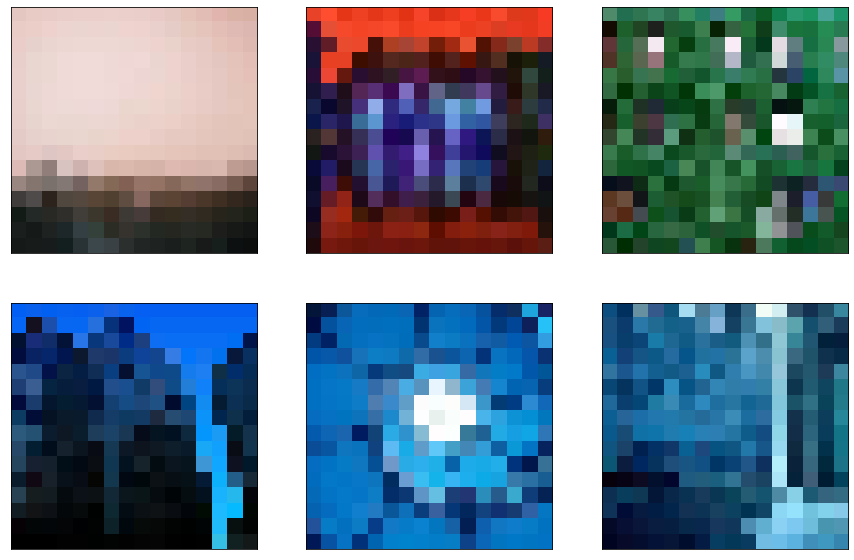

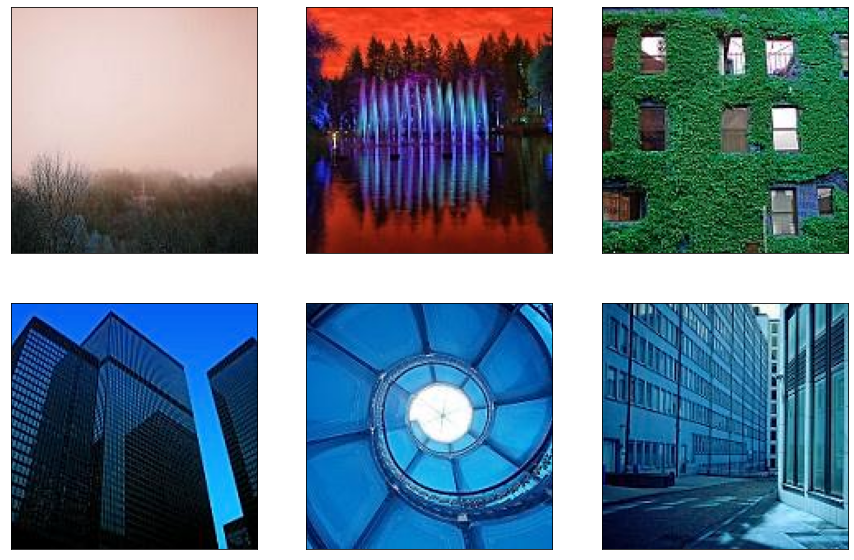

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


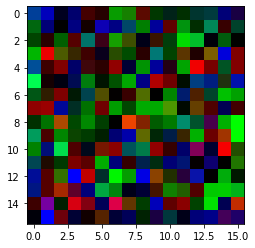

Execution time of CVX OPT is 78989.613ms
Accuracy =  83.75


In [6]:
start = datetime.now()

CVX = SVM_cvxopt(training_images, training_labels)
CVX.execute()

end = datetime.now()
td = (end - start).total_seconds() * 10**3
print(f"Execution time of CVX OPT is {td:.03f}ms")

_ = CVX.test(test_images, test_labels)

In [7]:
print("Number of support vectors: ", CVX.n_support_)
print("Percentage of support vectors: ", CVX.n_support_*100/CVX.X_train.shape[0])

Number of support vectors:  1400
Percentage of support vectors:  29.41176470588235


In [8]:
print("weights: ",CVX.w)

weights:  [[-8.89412707e-01]
 [ 2.50288226e-01]
 [ 6.03717580e-01]
 [-3.76781077e-01]
 [-4.12377792e-02]
 [ 7.39573142e-01]
 [-7.36291166e-02]
 [-8.10625966e-02]
 [ 1.29156941e-01]
 [-2.66576719e-01]
 [-9.84459292e-02]
 [ 4.28054433e-01]
 [ 2.68856459e-01]
 [-3.00396745e-01]
 [-3.66018479e-01]
 [ 1.49725018e-01]
 [-7.17169595e-02]
 [-1.01283606e-01]
 [ 2.76854904e-02]
 [ 6.14885661e-01]
 [-5.31213164e-01]
 [ 8.86535842e-02]
 [ 5.02280575e-01]
 [-2.00867125e-01]
 [ 3.59646289e-01]
 [ 4.11698558e-02]
 [-3.64983693e-01]
 [-1.66523950e-01]
 [ 2.19384987e-01]
 [-3.41826578e-02]
 [-5.87687223e-02]
 [ 1.36165387e-01]
 [ 9.66595224e-02]
 [-2.42520610e-01]
 [ 1.87378570e-01]
 [-6.83058722e-02]
 [-6.52092395e-01]
 [ 2.11555571e-01]
 [ 1.84870685e-01]
 [-7.16044714e-01]
 [ 2.34949891e-01]
 [ 2.42711415e-01]
 [-5.18980230e-01]
 [-9.63514711e-02]
 [ 4.68761326e-01]
 [ 9.85388128e-02]
 [-2.56077228e-01]
 [ 2.65795784e-01]
 [-5.63724730e-01]
 [ 4.06539779e-01]
 [ 6.16984860e-02]
 [-5.26732478e-01]
 [

In [9]:
print("bias: ",CVX.bias)

bias:  3.0239471949936387


In [10]:
print("indices of support vectors: ",CVX.support_)

indices of support vectors:  [   1    3    6 ... 4753 4756 4759]


#### Gaussian Kernel

In [11]:
start = datetime.now()

CVX_rbf = SVM_cvxopt_rbf(training_images, training_labels)
CVX_rbf.execute()

end = datetime.now()
td = (end - start).total_seconds() * 10**3
print(f"Execution time of CVX OPT is {td:.03f}ms")

_ = CVX_rbf.test(test_images, test_labels)

     pcost       dcost       gap    pres   dres
 0: -1.9393e+03 -1.4696e+04  9e+04  4e+00  4e-13
 1: -1.2731e+03 -1.0480e+04  2e+04  4e-01  5e-13
 2: -1.1845e+03 -2.6743e+03  1e+03  7e-13  4e-13
 3: -1.4357e+03 -2.1032e+03  7e+02  2e-13  4e-13
 4: -1.5025e+03 -1.9941e+03  5e+02  7e-13  4e-13
 5: -1.5733e+03 -1.8712e+03  3e+02  1e-12  4e-13
 6: -1.6192e+03 -1.7957e+03  2e+02  5e-13  4e-13
 7: -1.6452e+03 -1.7549e+03  1e+02  2e-12  4e-13
 8: -1.6661e+03 -1.7225e+03  6e+01  6e-13  4e-13
 9: -1.6769e+03 -1.7068e+03  3e+01  1e-12  4e-13
10: -1.6857e+03 -1.6947e+03  9e+00  7e-13  5e-13
11: -1.6890e+03 -1.6904e+03  1e+00  8e-13  5e-13
12: -1.6896e+03 -1.6897e+03  7e-02  1e-12  5e-13
13: -1.6896e+03 -1.6896e+03  2e-03  3e-13  5e-13
14: -1.6896e+03 -1.6896e+03  3e-05  1e-12  5e-13
Optimal solution found.
Execution time of CVX OPT is 83889.567ms
Accuracy =  84.5


In [12]:
print("Number of support vectors: ", CVX_rbf.n_support_)
print("Percentage of support vectors: ", CVX_rbf.n_support_*100/CVX.X_train.shape[0])

Number of support vectors:  1957
Percentage of support vectors:  41.11344537815126


In [13]:
print("bias: ",CVX_rbf.bias)

bias:  -7.770167168941587


In [14]:
print("indices of support vectors: ",CVX_rbf.support_)

indices of support vectors:  [   1    3    7 ... 4754 4756 4759]


In [15]:
print("number of support vector which are present in both linear as well as gaussian: ",len(set(CVX_rbf.support_) & set(CVX.support_)))

number of support vector which are present in both linear as well as gaussian:  1240


### SVM using scikit-learn

In [16]:
X_train, Y_train = SVM_cvxopt.get_matrix_form(training_images, training_labels, 16)
Y_train = Y_train.ravel()

In [17]:
X_test, Y_test = SVM_cvxopt.get_matrix_form(test_images, test_labels, 16)
Y_test = Y_test.ravel()

#### Using Linear Kernel

In [18]:
start = datetime.now()

# svc = SVC(kernel='linear')
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train, Y_train)

end = datetime.now()
td = (end - start).total_seconds() * 10**3
print(f"Execution time of SVM using scikit learn is {td:.03f}ms")

Execution time of SVM using scikit learn is 4968.793ms


In [19]:
Y_pred = svc_linear.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix of linear SVM')

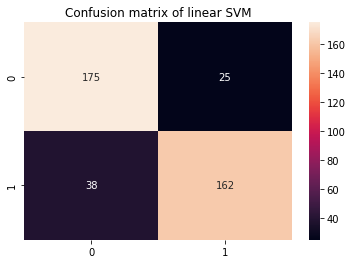

In [20]:
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

In [21]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

          -1       0.82      0.88      0.85       200
           1       0.87      0.81      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



In [22]:
print("Number of support vectors using scikit learn is ",svc_linear.n_support_.sum())

Number of support vectors using scikit learn is  1397


In [23]:
print("support vectors in both are ",len(set(CVX.support_) & set(svc_linear.support_)))

support vectors in both are  1397


In [24]:
print("Norm of w difference using scikit and cvxopt is ", np.linalg.norm(svc_linear.coef_-CVX.w.T))

Norm of w difference using scikit and cvxopt is  0.015276561889511025


In [25]:
print("Norm of b difference using scikit and cvxopt is ", np.linalg.norm(svc_linear.intercept_-CVX.bias))

Norm of b difference using scikit and cvxopt is  0.4846014732641839


#### Using Gaussian Kernel

In [26]:
start = datetime.now()

# svc = SVC(kernel='linear')
svc_rbf = SVC(kernel='rbf', gamma=0.001)
svc_rbf.fit(X_train, Y_train)

end = datetime.now()
td = (end - start).total_seconds() * 10**3
print(f"Execution time of SVM using scikit learn is {td:.03f}ms")

Execution time of SVM using scikit learn is 4145.652ms


In [27]:
Y_pred = svc_rbf.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix of Gaussian SVM')

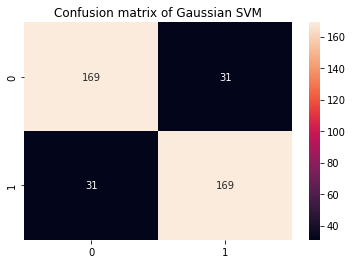

In [28]:
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of Gaussian SVM') # fmt='d' formats the numbers as digits, which means integers

In [29]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.84      0.84       200
           1       0.84      0.84      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



In [30]:
print("Number of support vectors using scikit learn is ",svc_rbf.n_support_.sum())

Number of support vectors using scikit learn is  1956


In [31]:
print("support vectors in both are ",len(set(CVX_rbf.support_) & set(svc_rbf.support_)))

support vectors in both are  1956


In [32]:
print("Norm of b difference using scikit and cvxopt is ", np.linalg.norm(svc_rbf.intercept_-CVX_rbf.bias))

Norm of b difference using scikit and cvxopt is  0.04363545053161211


#### Extra Fun : Increasing the resized feature size from 16 to 32

In [33]:
X_train, Y_train = SVM_cvxopt.get_matrix_form(training_images, training_labels, 32)
Y_train = Y_train.ravel()

In [34]:
X_test, Y_test = SVM_cvxopt.get_matrix_form(test_images, test_labels, 32)
Y_test = Y_test.ravel()

##### Linear kernel

In [35]:
start = datetime.now()

# svc = SVC(kernel='linear')
svc_linear32 = SVC(kernel='linear')
svc_linear32.fit(X_train, Y_train)

end = datetime.now()
td = (end - start).total_seconds() * 10**3
print(f"Execution time of SVM using scikit learn is {td:.03f}ms")

Execution time of SVM using scikit learn is 19881.270ms


In [36]:
Y_pred = svc_linear32.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix of linear SVM 32')

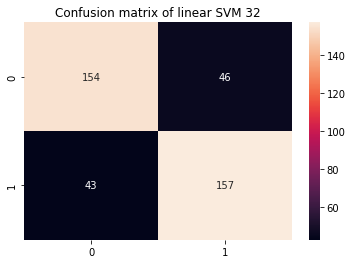

In [37]:
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM 32') # fmt='d' formats the numbers as digits, which means integers

In [38]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

          -1       0.78      0.77      0.78       200
           1       0.77      0.79      0.78       200

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



In [39]:
print("Number of support vectors using scikit learn is ",svc_linear32.n_support_.sum())

Number of support vectors using scikit learn is  1361


In [40]:
print("support vectors in both are ",len(set(CVX.support_) & set(svc_linear32.support_)))

support vectors in both are  882


##### Gaussian kernel

In [41]:
start = datetime.now()

# svc = SVC(kernel='linear')
svc_rbf32 = SVC(kernel='rbf', gamma=0.001)
svc_rbf32.fit(X_train, Y_train)

end = datetime.now()
td = (end - start).total_seconds() * 10**3
print(f"Execution time of SVM using scikit learn is {td:.03f}ms")

Execution time of SVM using scikit learn is 13366.478ms


In [42]:
Y_pred = svc_rbf32.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix of gaussian SVM 32')

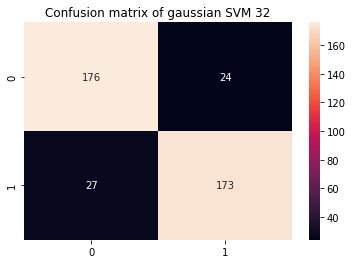

In [43]:
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of gaussian SVM 32') # fmt='d' formats the numbers as digits, which means integers

In [44]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.88      0.87       200
           1       0.88      0.86      0.87       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [45]:
print("Number of support vectors using scikit learn is ",svc_rbf32.n_support_.sum())

Number of support vectors using scikit learn is  1647


In [46]:
print("support vectors in both are ",len(set(CVX_rbf.support_) & set(svc_rbf32.support_)))

support vectors in both are  1548


## Multiclass classification

##### Below code generates some code to create 6C2 models (15 models)

In [ ]:
# ## Generator code
# lst = [(0,1),(0,2),(0,3),(0,4),(0,5),(1,2),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(3,4),(3,5),(4,5)]
# for x,y in lst:
#     print(f'# Binary classifier for class {x} and class {y}')
#     print(f'training_images_{x}_{y} = glob.glob("../svm/train/{x}/*.jpg") + glob.glob("../svm/train/{y}/*.jpg")')
#     print(f'training_labels_{x}_{y} = [-1 for i in range(len(training_images_{x}_{y})//2)] + [1 for i in range(len(training_images_{x}_{y})//2)]')
#     print("")
#     print(f'CVX_{x}_{y} = SVM_cvxopt_rbf(training_images_{x}_{y}, training_labels_{x}_{y})')
#     print(f'CVX_{x}_{y}.execute()')
#     print("")
#     print(f"file_{x}_{y} = open('CVX_{x}_{y}.obj','wb')")
#     print(f"pickle.dump(CVX_{x}_{y},file_{x}_{y})")
#     print(f"file_{x}_{y}.close()")
#     print("")
#     print(f"## {x} and {y} completed")
#     print("")

### Training

In [ ]:
# Binary classifier for class 0 and class 1
training_images_0_1 = glob.glob("../svm/train/0/*.jpg") + glob.glob("../svm/train/1/*.jpg")
training_labels_0_1 = [-1 for i in range(len(training_images_0_1)//2)] + [1 for i in range(len(training_images_0_1)//2)]

CVX_0_1 = SVM_cvxopt_rbf(training_images_0_1, training_labels_0_1)
CVX_0_1.execute()

file_0_1 = open('CVX_0_1.obj','wb')
pickle.dump(CVX_0_1,file_0_1)
file_0_1.close()

## 0 and 1 completed

# Binary classifier for class 0 and class 2
training_images_0_2 = glob.glob("../svm/train/0/*.jpg") + glob.glob("../svm/train/2/*.jpg")
training_labels_0_2 = [-1 for i in range(len(training_images_0_2)//2)] + [1 for i in range(len(training_images_0_2)//2)]

CVX_0_2 = SVM_cvxopt_rbf(training_images_0_2, training_labels_0_2)
CVX_0_2.execute()

file_0_2 = open('CVX_0_2.obj','wb')
pickle.dump(CVX_0_2,file_0_2)
file_0_2.close()

## 0 and 2 completed

# Binary classifier for class 0 and class 3
training_images_0_3 = glob.glob("../svm/train/0/*.jpg") + glob.glob("../svm/train/3/*.jpg")
training_labels_0_3 = [-1 for i in range(len(training_images_0_3)//2)] + [1 for i in range(len(training_images_0_3)//2)]

CVX_0_3 = SVM_cvxopt_rbf(training_images_0_3, training_labels_0_3)
CVX_0_3.execute()

file_0_3 = open('CVX_0_3.obj','wb')
pickle.dump(CVX_0_3,file_0_3)
file_0_3.close()

## 0 and 3 completed

# Binary classifier for class 0 and class 4
training_images_0_4 = glob.glob("../svm/train/0/*.jpg") + glob.glob("../svm/train/4/*.jpg")
training_labels_0_4 = [-1 for i in range(len(training_images_0_4)//2)] + [1 for i in range(len(training_images_0_4)//2)]

CVX_0_4 = SVM_cvxopt_rbf(training_images_0_4, training_labels_0_4)
CVX_0_4.execute()

file_0_4 = open('CVX_0_4.obj','wb')
pickle.dump(CVX_0_4,file_0_4)
file_0_4.close()

## 0 and 4 completed

# Binary classifier for class 0 and class 5
training_images_0_5 = glob.glob("../svm/train/0/*.jpg") + glob.glob("../svm/train/5/*.jpg")
training_labels_0_5 = [-1 for i in range(len(training_images_0_5)//2)] + [1 for i in range(len(training_images_0_5)//2)]

CVX_0_5 = SVM_cvxopt_rbf(training_images_0_5, training_labels_0_5)
CVX_0_5.execute()

file_0_5 = open('CVX_0_5.obj','wb')
pickle.dump(CVX_0_5,file_0_5)
file_0_5.close()

## 0 and 5 completed

# Binary classifier for class 1 and class 2
training_images_1_2 = glob.glob("../svm/train/1/*.jpg") + glob.glob("../svm/train/2/*.jpg")
training_labels_1_2 = [-1 for i in range(len(training_images_1_2)//2)] + [1 for i in range(len(training_images_1_2)//2)]

CVX_1_2 = SVM_cvxopt_rbf(training_images_1_2, training_labels_1_2)
CVX_1_2.execute()

file_1_2 = open('CVX_1_2.obj','wb')
pickle.dump(CVX_1_2,file_1_2)
file_1_2.close()

## 1 and 2 completed

# Binary classifier for class 1 and class 3
training_images_1_3 = glob.glob("../svm/train/1/*.jpg") + glob.glob("../svm/train/3/*.jpg")
training_labels_1_3 = [-1 for i in range(len(training_images_1_3)//2)] + [1 for i in range(len(training_images_1_3)//2)]

CVX_1_3 = SVM_cvxopt_rbf(training_images_1_3, training_labels_1_3)
CVX_1_3.execute()

file_1_3 = open('CVX_1_3.obj','wb')
pickle.dump(CVX_1_3,file_1_3)
file_1_3.close()

## 1 and 3 completed

# Binary classifier for class 1 and class 4
training_images_1_4 = glob.glob("../svm/train/1/*.jpg") + glob.glob("../svm/train/4/*.jpg")
training_labels_1_4 = [-1 for i in range(len(training_images_1_4)//2)] + [1 for i in range(len(training_images_1_4)//2)]

CVX_1_4 = SVM_cvxopt_rbf(training_images_1_4, training_labels_1_4)
CVX_1_4.execute()

file_1_4 = open('CVX_1_4.obj','wb')
pickle.dump(CVX_1_4,file_1_4)
file_1_4.close()

## 1 and 4 completed

# Binary classifier for class 1 and class 5
training_images_1_5 = glob.glob("../svm/train/1/*.jpg") + glob.glob("../svm/train/5/*.jpg")
training_labels_1_5 = [-1 for i in range(len(training_images_1_5)//2)] + [1 for i in range(len(training_images_1_5)//2)]

CVX_1_5 = SVM_cvxopt_rbf(training_images_1_5, training_labels_1_5)
CVX_1_5.execute()

file_1_5 = open('CVX_1_5.obj','wb')
pickle.dump(CVX_1_5,file_1_5)
file_1_5.close()

## 1 and 5 completed

# Binary classifier for class 2 and class 3
training_images_2_3 = glob.glob("../svm/train/2/*.jpg") + glob.glob("../svm/train/3/*.jpg")
training_labels_2_3 = [-1 for i in range(len(training_images_2_3)//2)] + [1 for i in range(len(training_images_2_3)//2)]

CVX_2_3 = SVM_cvxopt_rbf(training_images_2_3, training_labels_2_3)
CVX_2_3.execute()

file_2_3 = open('CVX_2_3.obj','wb')
pickle.dump(CVX_2_3,file_2_3)
file_2_3.close()

## 2 and 3 completed

# Binary classifier for class 2 and class 4
training_images_2_4 = glob.glob("../svm/train/2/*.jpg") + glob.glob("../svm/train/4/*.jpg")
training_labels_2_4 = [-1 for i in range(len(training_images_2_4)//2)] + [1 for i in range(len(training_images_2_4)//2)]

CVX_2_4 = SVM_cvxopt_rbf(training_images_2_4, training_labels_2_4)
CVX_2_4.execute()

file_2_4 = open('CVX_2_4.obj','wb')
pickle.dump(CVX_2_4,file_2_4)
file_2_4.close()

## 2 and 4 completed

# Binary classifier for class 2 and class 5
training_images_2_5 = glob.glob("../svm/train/2/*.jpg") + glob.glob("../svm/train/5/*.jpg")
training_labels_2_5 = [-1 for i in range(len(training_images_2_5)//2)] + [1 for i in range(len(training_images_2_5)//2)]

CVX_2_5 = SVM_cvxopt_rbf(training_images_2_5, training_labels_2_5)
CVX_2_5.execute()

file_2_5 = open('CVX_2_5.obj','wb')
pickle.dump(CVX_2_5,file_2_5)
file_2_5.close()

## 2 and 5 completed

# Binary classifier for class 3 and class 4
training_images_3_4 = glob.glob("../svm/train/3/*.jpg") + glob.glob("../svm/train/4/*.jpg")
training_labels_3_4 = [-1 for i in range(len(training_images_3_4)//2)] + [1 for i in range(len(training_images_3_4)//2)]

CVX_3_4 = SVM_cvxopt_rbf(training_images_3_4, training_labels_3_4)
CVX_3_4.execute()

file_3_4 = open('CVX_3_4.obj','wb')
pickle.dump(CVX_3_4,file_3_4)
file_3_4.close()

## 3 and 4 completed

# Binary classifier for class 3 and class 5
training_images_3_5 = glob.glob("../svm/train/3/*.jpg") + glob.glob("../svm/train/5/*.jpg")
training_labels_3_5 = [-1 for i in range(len(training_images_3_5)//2)] + [1 for i in range(len(training_images_3_5)//2)]

CVX_3_5 = SVM_cvxopt_rbf(training_images_3_5, training_labels_3_5)
CVX_3_5.execute()

file_3_5 = open('CVX_3_5.obj','wb')
pickle.dump(CVX_3_5,file_3_5)
file_3_5.close()

## 3 and 5 completed

# Binary classifier for class 4 and class 5
training_images_4_5 = glob.glob("../svm/train/4/*.jpg") + glob.glob("../svm/train/5/*.jpg")
training_labels_4_5 = [-1 for i in range(len(training_images_4_5)//2)] + [1 for i in range(len(training_images_4_5)//2)]

CVX_4_5 = SVM_cvxopt_rbf(training_images_4_5, training_labels_4_5)
CVX_4_5.execute()

file_4_5 = open('CVX_4_5.obj','wb')
pickle.dump(CVX_4_5,file_4_5)
file_4_5.close()

## 4 and 5 completed

In [16]:
## Generator code
lst = [(0,1),(0,2),(0,3),(0,4),(0,5),(1,2),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(3,4),(3,5),(4,5)]
for x,y in lst:
    print(f"file_{x}_{y} = open('CVX_{x}_{y}.obj','rb')")
    print(f"CVX_{x}_{y}= pickle.load(file_{x}_{y})")
    print(f"file_{x}_{y}.close()")
    print(f"Y_pred_{x}_{y}= CVX_{x}_{y}.test(test_images,test_labels)")
    print("")
    print(f"Y_pred_{x}_{y}_val = np.zeros(Y_pred_{x}_{y}.shape)")
    print(f"for i in range(Y_pred_{x}_{y}.shape[0]):")
    print(f"\tif Y_pred_{x}_{y}[i][0] == -1:")
    print(f"\t\tY_pred_{x}_{y}_val[i][0] = {x}")
    print(f"\telse:")
    print(f"\t\tY_pred_{x}_{y}_val[i][0] = {y}")
    print("")
    print(f"## {x} and {y} completed")
    print("")

file_0_1 = open('CVX_0_1.obj','rb')
CVX_0_1= pickle.load(file_0_1)
file_0_1.close()
Y_pred_0_1= CVX_0_1.test(test_images,test_labels)

Y_pred_0_1_val = np.zeros(Y_pred_0_1.shape)
for i in range(Y_pred_0_1.shape[0]):
	if Y_pred_0_1[i][0] == -1:
		Y_pred_0_1_val[i][0] = 0
	else:
		Y_pred_0_1_val[i][0] = 1

## 0 and 1 completed

file_0_2 = open('CVX_0_2.obj','rb')
CVX_0_2= pickle.load(file_0_2)
file_0_2.close()
Y_pred_0_2= CVX_0_2.test(test_images,test_labels)

Y_pred_0_2_val = np.zeros(Y_pred_0_2.shape)
for i in range(Y_pred_0_2.shape[0]):
	if Y_pred_0_2[i][0] == -1:
		Y_pred_0_2_val[i][0] = 0
	else:
		Y_pred_0_2_val[i][0] = 2

## 0 and 2 completed

file_0_3 = open('CVX_0_3.obj','rb')
CVX_0_3= pickle.load(file_0_3)
file_0_3.close()
Y_pred_0_3= CVX_0_3.test(test_images,test_labels)

Y_pred_0_3_val = np.zeros(Y_pred_0_3.shape)
for i in range(Y_pred_0_3.shape[0]):
	if Y_pred_0_3[i][0] == -1:
		Y_pred_0_3_val[i][0] = 0
	else:
		Y_pred_0_3_val[i][0] = 3

## 0 and 3 completed

file_0_4 = open(

### Testing

In [6]:
test_images = glob.glob("../svm/val/0/*.jpg") + glob.glob("../svm/val/1/*.jpg") + glob.glob("../svm/val/2/*.jpg") + glob.glob("../svm/val/3/*.jpg") + glob.glob("../svm/val/4/*.jpg") + glob.glob("../svm/val/5/*.jpg")
test_labels = [0 for i in range(len(test_images)//6)] + [1 for i in range(len(test_images)//6)] + [2 for i in range(len(test_images)//6)] + [3 for i in range(len(test_images)//6)] + [4 for i in range(len(test_images)//6)] + [5 for i in range(len(test_images)//6)]

In [7]:
X_test, Y_test = SVM_cvxopt.get_matrix_form(test_images, test_labels, 16)
Y_test = Y_test.ravel()

In [7]:
file_0_1 = open('CVX_0_1.obj','rb')
CVX_0_1= pickle.load(file_0_1)
file_0_1.close()
Y_pred_0_1= CVX_0_1.test(test_images,test_labels)

Y_pred_0_1_val = np.zeros(Y_pred_0_1.shape)
for i in range(Y_pred_0_1.shape[0]):
	if Y_pred_0_1[i][0] == -1:
		Y_pred_0_1_val[i][0] = 0
	else:
		Y_pred_0_1_val[i][0] = 1

## 0 and 1 completed

file_0_2 = open('CVX_0_2.obj','rb')
CVX_0_2= pickle.load(file_0_2)
file_0_2.close()
Y_pred_0_2= CVX_0_2.test(test_images,test_labels)

Y_pred_0_2_val = np.zeros(Y_pred_0_2.shape)
for i in range(Y_pred_0_2.shape[0]):
	if Y_pred_0_2[i][0] == -1:
		Y_pred_0_2_val[i][0] = 0
	else:
		Y_pred_0_2_val[i][0] = 2

## 0 and 2 completed

file_0_3 = open('CVX_0_3.obj','rb')
CVX_0_3= pickle.load(file_0_3)
file_0_3.close()
Y_pred_0_3= CVX_0_3.test(test_images,test_labels)

Y_pred_0_3_val = np.zeros(Y_pred_0_3.shape)
for i in range(Y_pred_0_3.shape[0]):
	if Y_pred_0_3[i][0] == -1:
		Y_pred_0_3_val[i][0] = 0
	else:
		Y_pred_0_3_val[i][0] = 3

## 0 and 3 completed

file_0_4 = open('CVX_0_4.obj','rb')
CVX_0_4= pickle.load(file_0_4)
file_0_4.close()
Y_pred_0_4= CVX_0_4.test(test_images,test_labels)

Y_pred_0_4_val = np.zeros(Y_pred_0_4.shape)
for i in range(Y_pred_0_4.shape[0]):
	if Y_pred_0_4[i][0] == -1:
		Y_pred_0_4_val[i][0] = 0
	else:
		Y_pred_0_4_val[i][0] = 4

## 0 and 4 completed

file_0_5 = open('CVX_0_5.obj','rb')
CVX_0_5= pickle.load(file_0_5)
file_0_5.close()
Y_pred_0_5= CVX_0_5.test(test_images,test_labels)

Y_pred_0_5_val = np.zeros(Y_pred_0_5.shape)
for i in range(Y_pred_0_5.shape[0]):
	if Y_pred_0_5[i][0] == -1:
		Y_pred_0_5_val[i][0] = 0
	else:
		Y_pred_0_5_val[i][0] = 5

## 0 and 5 completed

Y_pred_first5_votes = np.hstack((Y_pred_0_1_val, Y_pred_0_2_val, Y_pred_0_3_val, Y_pred_0_4_val, Y_pred_0_5_val))
np.save("Y_pred_first5_votes.npy", Y_pred_first5_votes)

Accuracy =  13.916666666666666
Accuracy =  0.9166666666666666
Accuracy =  0.75
Accuracy =  3.4166666666666665
Accuracy =  13.916666666666666


In [10]:
file_1_2 = open('CVX_1_2.obj','rb')
CVX_1_2= pickle.load(file_1_2)
file_1_2.close()
Y_pred_1_2= CVX_1_2.test(test_images,test_labels)

Y_pred_1_2_val = np.zeros(Y_pred_1_2.shape)
for i in range(Y_pred_1_2.shape[0]):
	if Y_pred_1_2[i][0] == -1:
		Y_pred_1_2_val[i][0] = 1
	else:
		Y_pred_1_2_val[i][0] = 2

## 1 and 2 completed

file_1_3 = open('CVX_1_3.obj','rb')
CVX_1_3= pickle.load(file_1_3)
file_1_3.close()
Y_pred_1_3= CVX_1_3.test(test_images,test_labels)

Y_pred_1_3_val = np.zeros(Y_pred_1_3.shape)
for i in range(Y_pred_1_3.shape[0]):
	if Y_pred_1_3[i][0] == -1:
		Y_pred_1_3_val[i][0] = 1
	else:
		Y_pred_1_3_val[i][0] = 3

## 1 and 3 completed

file_1_4 = open('CVX_1_4.obj','rb')
CVX_1_4= pickle.load(file_1_4)
file_1_4.close()
Y_pred_1_4= CVX_1_4.test(test_images,test_labels)

Y_pred_1_4_val = np.zeros(Y_pred_1_4.shape)
for i in range(Y_pred_1_4.shape[0]):
	if Y_pred_1_4[i][0] == -1:
		Y_pred_1_4_val[i][0] = 1
	else:
		Y_pred_1_4_val[i][0] = 4

## 1 and 4 completed

file_1_5 = open('CVX_1_5.obj','rb')
CVX_1_5= pickle.load(file_1_5)
file_1_5.close()
Y_pred_1_5= CVX_1_5.test(test_images,test_labels)

Y_pred_1_5_val = np.zeros(Y_pred_1_5.shape)
for i in range(Y_pred_1_5.shape[0]):
	if Y_pred_1_5[i][0] == -1:
		Y_pred_1_5_val[i][0] = 1
	else:
		Y_pred_1_5_val[i][0] = 5

## 1 and 5 completed

file_2_3 = open('CVX_2_3.obj','rb')
CVX_2_3= pickle.load(file_2_3)
file_2_3.close()
Y_pred_2_3= CVX_2_3.test(test_images,test_labels)

Y_pred_2_3_val = np.zeros(Y_pred_2_3.shape)
for i in range(Y_pred_2_3.shape[0]):
	if Y_pred_2_3[i][0] == -1:
		Y_pred_2_3_val[i][0] = 2
	else:
		Y_pred_2_3_val[i][0] = 3

## 2 and 3 completed

Y_pred_middle5_votes = np.hstack((Y_pred_1_2_val, Y_pred_1_3_val, Y_pred_1_4_val, Y_pred_1_5_val, Y_pred_2_3_val))
np.save("Y_pred_middle5_votes.npy", Y_pred_middle5_votes)

Accuracy =  1.3333333333333333
Accuracy =  1.5833333333333333
Accuracy =  2.4166666666666665
Accuracy =  3.3333333333333335
Accuracy =  10.5


In [8]:
file_2_4 = open('CVX_2_4.obj','rb')
CVX_2_4= pickle.load(file_2_4)
file_2_4.close()
Y_pred_2_4= CVX_2_4.test(test_images,test_labels)

Y_pred_2_4_val = np.zeros(Y_pred_2_4.shape)
for i in range(Y_pred_2_4.shape[0]):
	if Y_pred_2_4[i][0] == -1:
		Y_pred_2_4_val[i][0] = 2
	else:
		Y_pred_2_4_val[i][0] = 4

## 2 and 4 completed

file_2_5 = open('CVX_2_5.obj','rb')
CVX_2_5= pickle.load(file_2_5)
file_2_5.close()
Y_pred_2_5= CVX_2_5.test(test_images,test_labels)

Y_pred_2_5_val = np.zeros(Y_pred_2_5.shape)
for i in range(Y_pred_2_5.shape[0]):
	if Y_pred_2_5[i][0] == -1:
		Y_pred_2_5_val[i][0] = 2
	else:
		Y_pred_2_5_val[i][0] = 5

## 2 and 5 completed

file_3_4 = open('CVX_3_4.obj','rb')
CVX_3_4= pickle.load(file_3_4)
file_3_4.close()
Y_pred_3_4= CVX_3_4.test(test_images,test_labels)

Y_pred_3_4_val = np.zeros(Y_pred_3_4.shape)
for i in range(Y_pred_3_4.shape[0]):
	if Y_pred_3_4[i][0] == -1:
		Y_pred_3_4_val[i][0] = 3
	else:
		Y_pred_3_4_val[i][0] = 4

## 3 and 4 completed

file_3_5 = open('CVX_3_5.obj','rb')
CVX_3_5= pickle.load(file_3_5)
file_3_5.close()
Y_pred_3_5= CVX_3_5.test(test_images,test_labels)

Y_pred_3_5_val = np.zeros(Y_pred_3_5.shape)
for i in range(Y_pred_3_5.shape[0]):
	if Y_pred_3_5[i][0] == -1:
		Y_pred_3_5_val[i][0] = 3
	else:
		Y_pred_3_5_val[i][0] = 5

## 3 and 5 completed

file_4_5 = open('CVX_4_5.obj','rb')
CVX_4_5= pickle.load(file_4_5)
file_4_5.close()
Y_pred_4_5= CVX_4_5.test(test_images,test_labels)

Y_pred_4_5_val = np.zeros(Y_pred_4_5.shape)
for i in range(Y_pred_4_5.shape[0]):
	if Y_pred_4_5[i][0] == -1:
		Y_pred_4_5_val[i][0] = 4
	else:
		Y_pred_4_5_val[i][0] = 5

## 4 and 5 completed

Y_pred_last5_votes = np.hstack((Y_pred_2_4_val, Y_pred_2_5_val, Y_pred_3_4_val, Y_pred_3_5_val, Y_pred_4_5_val))
np.save("Y_pred_last5_votes.npy", Y_pred_last5_votes)

Accuracy =  15.916666666666666
Accuracy =  16.166666666666668
Accuracy =  15.416666666666666
Accuracy =  15.666666666666666
Accuracy =  13.75


In [9]:
## Since the models are too large in size, I calculated them i chunks and stored it in a file

In [10]:
Y_pred_first5_votes = np.load("Y_pred_first5_votes.npy")
Y_pred_middle5_votes = np.load("Y_pred_middle5_votes.npy")
Y_pred_last5_votes = np.load("Y_pred_last5_votes.npy")

In [11]:
Y_pred_all_votes = np.hstack((Y_pred_first5_votes,Y_pred_middle5_votes,Y_pred_last5_votes))

In [14]:
Y_pred_all_votes[0]

array([0., 0., 0., 4., 5., 1., 1., 4., 5., 2., 4., 5., 4., 5., 5.])

In [15]:
Y_pred_mc_cvx = np.zeros((Y_pred_all_votes.shape[0],1))
for i in range(Y_pred_all_votes.shape[0]):
    Y_pred_mc_cvx[i][0] = most_frequent(Y_pred_all_votes[i])

Text(0.5, 1.0, 'Confusion matrix of Gaussian SVM')

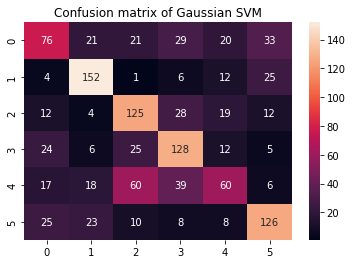

In [16]:
cm = confusion_matrix(Y_test,Y_pred_mc_cvx)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of Gaussian SVM') # fmt='d' formats the numbers as digits, which means integers

In [17]:
print(classification_report(Y_test,Y_pred_mc_cvx))

              precision    recall  f1-score   support

           0       0.48      0.38      0.42       200
           1       0.68      0.76      0.72       200
           2       0.52      0.62      0.57       200
           3       0.54      0.64      0.58       200
           4       0.46      0.30      0.36       200
           5       0.61      0.63      0.62       200

    accuracy                           0.56      1200
   macro avg       0.55      0.56      0.55      1200
weighted avg       0.55      0.56      0.55      1200



#### Multiclass classification using scikit-learn

In [24]:
training_images = glob.glob("../svm/train/0/*.jpg") + glob.glob("../svm/train/1/*.jpg") + glob.glob("../svm/train/2/*.jpg") + glob.glob("../svm/train/3/*.jpg") + glob.glob("../svm/train/4/*.jpg") + glob.glob("../svm/train/5/*.jpg")
training_labels = [0 for i in range(len(training_images)//6)] + [1 for i in range(len(training_images)//6)] + [2 for i in range(len(training_images)//6)] + [3 for i in range(len(training_images)//6)] + [4 for i in range(len(training_images)//6)] + [5 for i in range(len(training_images)//6)]

X_train, Y_train = SVM_cvxopt.get_matrix_form(training_images, training_labels, 16)
Y_train = Y_train.ravel()

In [25]:
start = datetime.now()

svm_mc = SVC(C=1.0, gamma=0.001, decision_function_shape='ovo')
svm_mc.fit(X_train, Y_train)

end = datetime.now()
td = (end - start).total_seconds() * 10**3
print(f"Execution time of SVM using scikit learn is {td:.03f}ms")

Execution time of SVM using scikit learn is 71612.690ms


In [26]:
Y_pred_mc_sci = svm_mc.predict(X_test)

In [27]:
Y_pred_mc_sci

array([5, 5, 1, ..., 0, 5, 5])

Text(0.5, 1.0, 'Confusion matrix of Gaussian SVM')

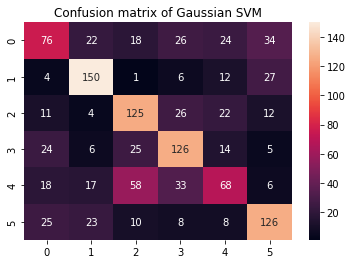

In [28]:
cm = confusion_matrix(Y_test,Y_pred_mc_sci)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of Gaussian SVM') # fmt='d' formats the numbers as digits, which means integers

In [29]:
print(classification_report(Y_test,Y_pred_mc_sci))

              precision    recall  f1-score   support

           0       0.48      0.38      0.42       200
           1       0.68      0.75      0.71       200
           2       0.53      0.62      0.57       200
           3       0.56      0.63      0.59       200
           4       0.46      0.34      0.39       200
           5       0.60      0.63      0.61       200

    accuracy                           0.56      1200
   macro avg       0.55      0.56      0.55      1200
weighted avg       0.55      0.56      0.55      1200



##### plot 12 misclassified images

In [44]:
# 'buildings' -> 0,
# 'forest' -> 1,
# 'glacier' -> 2,
# 'mountain' -> 3,
# 'sea' -> 4,
# 'street' -> 5
class_2_str = {
    0:'buildings',
    1:'forest',
    2:'glacier',
    3:'mountain',
    4:'sea',
    5:'street'
}

In [45]:
misclassified = []
for i in range(Y_test.shape[0]):
    if Y_test[i] != Y_pred_mc_sci[i]:
        misclassified.append((i,Y_test[i],Y_pred_mc_sci[i]))

misclassified_12 = random.sample(misclassified, 12)

In [49]:
misclassified_12[0][0]

686

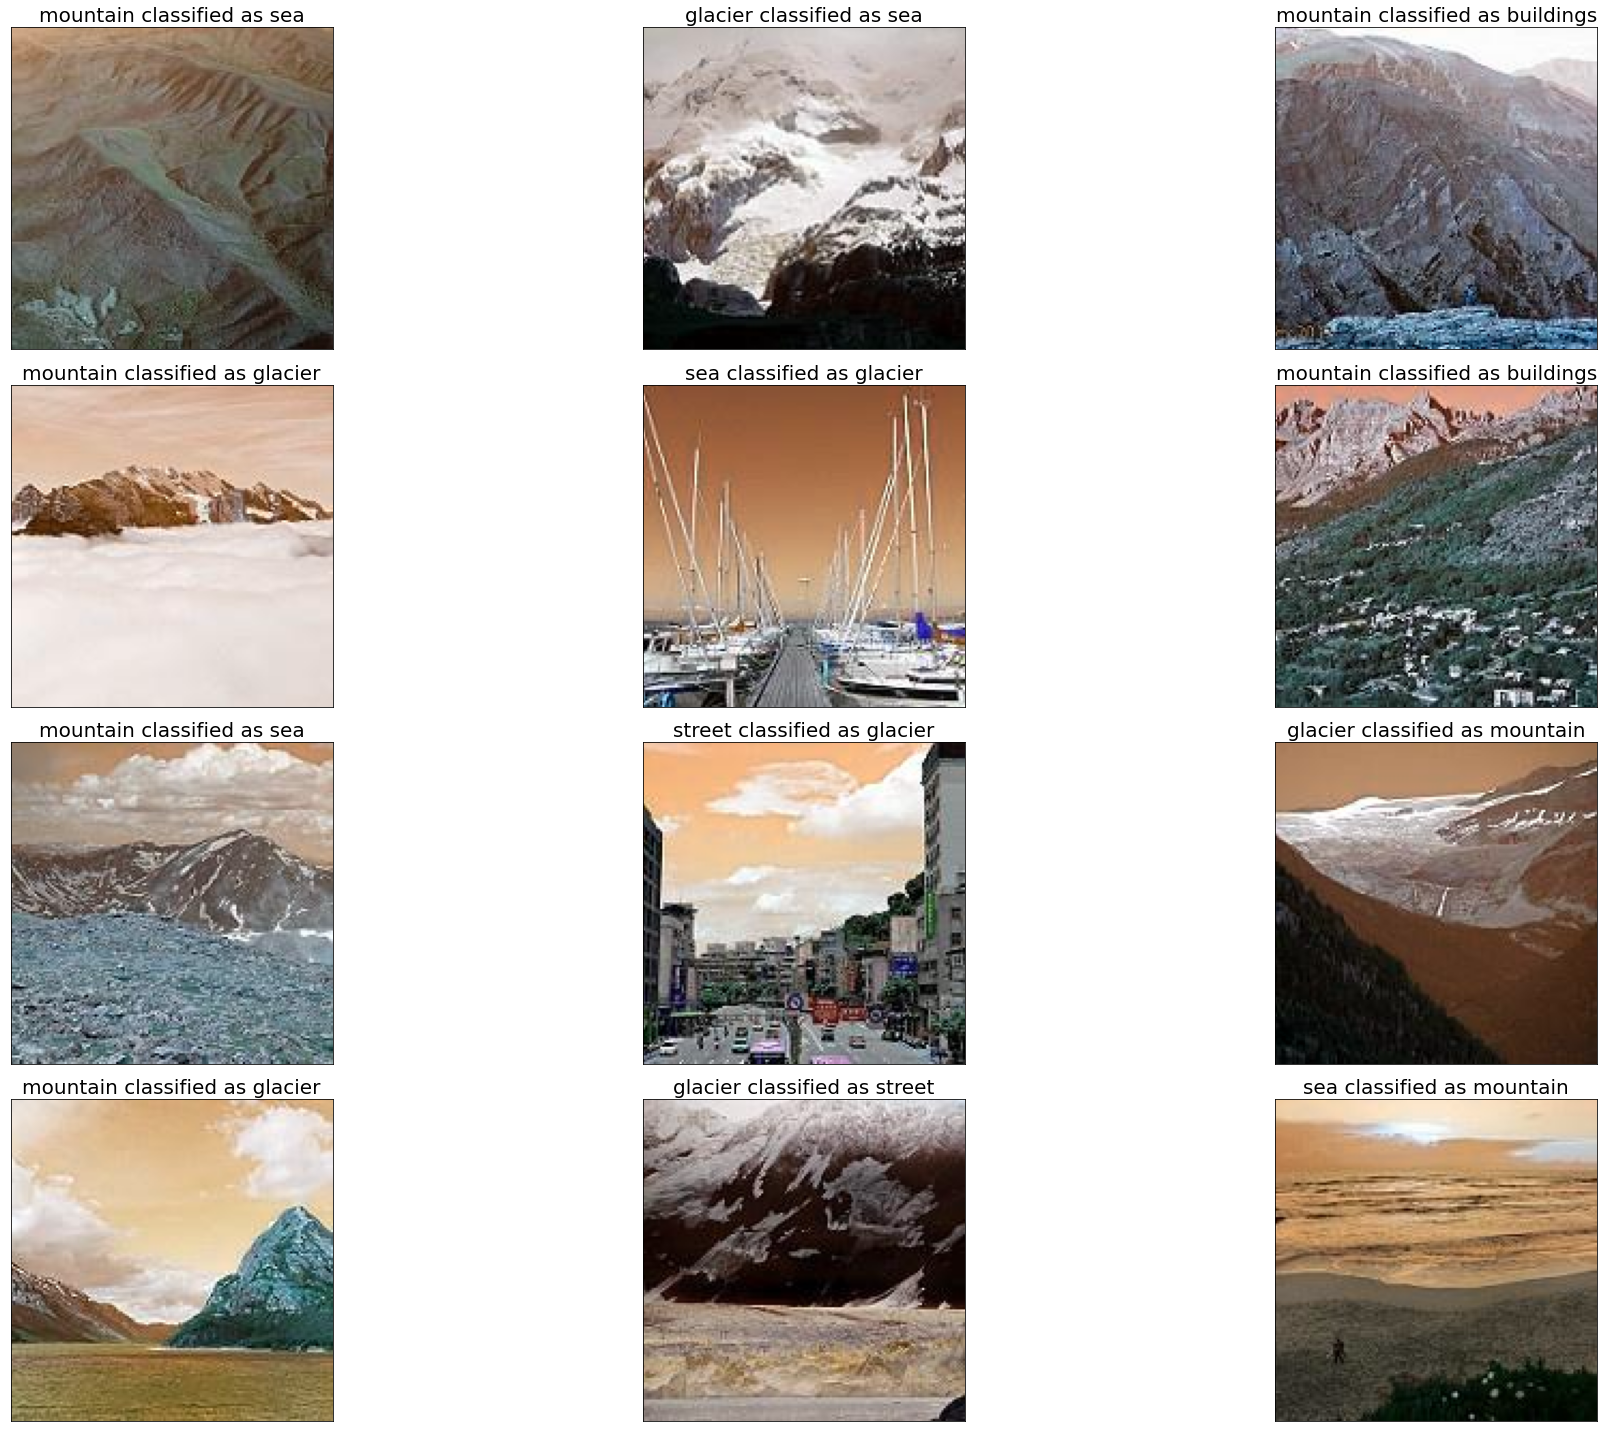

In [57]:
fig, axs = plt.subplots(4,3,figsize=(30,20)) # 4 rows, 3 per row 

img1 = cv2.imread(test_images[misclassified_12[0][0]])
img2 = cv2.imread(test_images[misclassified_12[1][0]])
img3 = cv2.imread(test_images[misclassified_12[2][0]])
img4 = cv2.imread(test_images[misclassified_12[3][0]])
img5 = cv2.imread(test_images[misclassified_12[4][0]])
img6 = cv2.imread(test_images[misclassified_12[5][0]])
img7 = cv2.imread(test_images[misclassified_12[6][0]])
img8 = cv2.imread(test_images[misclassified_12[7][0]])
img9 = cv2.imread(test_images[misclassified_12[8][0]])
img10 = cv2.imread(test_images[misclassified_12[9][0]])
img11 = cv2.imread(test_images[misclassified_12[10][0]])
img12 = cv2.imread(test_images[misclassified_12[11][0]])



axs[0, 0].imshow(img1) # Place img1 at position (0,0)
axs[0, 0].set_title(class_2_str[misclassified_12[0][1]]+' classified as '+class_2_str[misclassified_12[0][2]], fontsize=20)
axs[0, 1].imshow(img2) # Place img2 at position (0,1)
axs[0, 1].set_title(class_2_str[misclassified_12[1][1]]+' classified as '+class_2_str[misclassified_12[1][2]], fontsize=20)
axs[0, 2].imshow(img3) # Place img3 at position (0,2)
axs[0, 2].set_title(class_2_str[misclassified_12[2][1]]+' classified as '+class_2_str[misclassified_12[2][2]], fontsize=20)

axs[1, 0].imshow(img4) # Place img4 at position (1,0)
axs[1, 0].set_title(class_2_str[misclassified_12[3][1]]+' classified as '+class_2_str[misclassified_12[3][2]], fontsize=20)
axs[1, 1].imshow(img5) # Place img5 at position (1,1)
axs[1, 1].set_title(class_2_str[misclassified_12[4][1]]+' classified as '+class_2_str[misclassified_12[4][2]], fontsize=20)
axs[1, 2].imshow(img6) # Place img6 at position (1,2)
axs[1, 2].set_title(class_2_str[misclassified_12[5][1]]+' classified as '+class_2_str[misclassified_12[5][2]], fontsize=20)

axs[2, 0].imshow(img7) # Place img7 at position (2,0)
axs[2, 0].set_title(class_2_str[misclassified_12[6][1]]+' classified as '+class_2_str[misclassified_12[6][2]], fontsize=20)
axs[2, 1].imshow(img8) # Place img8 at position (2,1)
axs[2, 1].set_title(class_2_str[misclassified_12[7][1]]+' classified as '+class_2_str[misclassified_12[7][2]], fontsize=20)
axs[2, 2].imshow(img9) # Place img9 at position (2,2)
axs[2, 2].set_title(class_2_str[misclassified_12[8][1]]+' classified as '+class_2_str[misclassified_12[8][2]], fontsize=20)

axs[3, 0].imshow(img10) # Place img10 at position (3,0)
axs[3, 0].set_title(class_2_str[misclassified_12[9][1]]+' classified as '+class_2_str[misclassified_12[9][2]], fontsize=20)
axs[3, 1].imshow(img11) # Place img11 at position (3,1)
axs[3, 1].set_title(class_2_str[misclassified_12[10][1]]+' classified as '+class_2_str[misclassified_12[10][2]], fontsize=20)
axs[3, 2].imshow(img12) # Place img12 at position (3,2)
axs[3, 2].set_title(class_2_str[misclassified_12[11][1]]+' classified as '+class_2_str[misclassified_12[11][2]], fontsize=20)

#To hide x, y tick values
for row in axs:
    for ax in row:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

plt.tight_layout()
        
plt.show()

#### 5 fold validation

In [5]:
def get_accuracy(Y_test, Y_pred):
    #Accuracy
    accuracy = 0
    for i in range(Y_test.shape[0]):
        if Y_test[i] == Y_pred[i]:
            accuracy += 1

    return accuracy*100.0/Y_test.shape[0]

In [15]:
from sklearn.model_selection import KFold
import numpy as np

# Generate some dummy data
training_images = glob.glob("../svm/train/0/*.jpg") + glob.glob("../svm/train/1/*.jpg") + glob.glob("../svm/train/2/*.jpg") + glob.glob("../svm/train/3/*.jpg") + glob.glob("../svm/train/4/*.jpg") + glob.glob("../svm/train/5/*.jpg")
training_labels = [0 for i in range(len(training_images)//6)] + [1 for i in range(len(training_images)//6)] + [2 for i in range(len(training_images)//6)] + [3 for i in range(len(training_images)//6)] + [4 for i in range(len(training_images)//6)] + [5 for i in range(len(training_images)//6)]

combined = list(zip(training_images, training_labels))
random.shuffle(combined)

training_images, training_labels = zip(*combined)

X, Y = SVM_cvxopt.get_matrix_form(training_images, training_labels, 16)

# Create a 5-fold cross-validator
kfold = KFold(n_splits=5)

#Cross validation accuracy
cross_val_acc = 0

# Split the data into 5 folds
fold = 1
for train_index, val_index in kfold.split(X):
    print("Fold", fold)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    Y_train = Y_train.ravel()
    Y_val = Y_val.ravel()

    svm_mc_cv = SVC(C=10, gamma=0.001, decision_function_shape='ovo')

    svm_mc_cv.fit(X_train, Y_train)

    Y_pred = svm_mc_cv.predict(X_val)

    cross_val_acc += get_accuracy(Y_val, Y_pred)

    print("cross validation acc : ",cross_val_acc)

    fold += 1
    
cross_val_acc /= 5

Fold 1
cross validation acc :  58.088235294117645
Fold 2
cross validation acc :  117.15686274509804
Fold 3
cross validation acc :  175.80532212885154
Fold 4
cross validation acc :  235.43417366946778
Fold 5
cross validation acc :  293.9075630252101


In [16]:
print("cross validation accuracy :",cross_val_acc)

cross validation accuracy : 58.78151260504202


#### Plotting the graph of cross validation accuracy and validation accuracy 

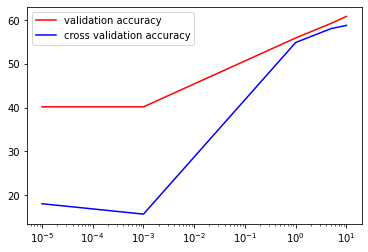

In [21]:
x = [0.00001, 0.001, 1, 5, 10]
y1 = [40.166, 40.166, 55.916, 59.25, 60.833]
y2 = [18.018, 15.644, 54.873, 58.060, 58.781]

# Plotting the first graph
plt.plot(x, y1, label='validation accuracy', color='red')

# Plotting the second graph
plt.plot(x, y2, label='cross validation accuracy', color='blue')

plt.xscale('log')
# plt.yscale('log')

plt.legend()

plt.show()

In [83]:
# Generate some dummy data
training_images = glob.glob("../svm/train/0/*.jpg") + glob.glob("../svm/train/1/*.jpg") + glob.glob("../svm/train/2/*.jpg") + glob.glob("../svm/train/3/*.jpg") + glob.glob("../svm/train/4/*.jpg") + glob.glob("../svm/train/5/*.jpg")
training_labels = [0 for i in range(len(training_images)//6)] + [1 for i in range(len(training_images)//6)] + [2 for i in range(len(training_images)//6)] + [3 for i in range(len(training_images)//6)] + [4 for i in range(len(training_images)//6)] + [5 for i in range(len(training_images)//6)]

X_train, Y_train = SVM_cvxopt.get_matrix_form(training_images, training_labels, 16)
Y_train = Y_train.ravel()

test_images = glob.glob("../svm/val/0/*.jpg") + glob.glob("../svm/val/1/*.jpg") + glob.glob("../svm/val/2/*.jpg") + glob.glob("../svm/val/3/*.jpg") + glob.glob("../svm/val/4/*.jpg") + glob.glob("../svm/val/5/*.jpg")
test_labels = [0 for i in range(len(test_images)//6)] + [1 for i in range(len(test_images)//6)] + [2 for i in range(len(test_images)//6)] + [3 for i in range(len(test_images)//6)] + [4 for i in range(len(test_images)//6)] + [5 for i in range(len(test_images)//6)]

X_test, Y_test = SVM_cvxopt.get_matrix_form(test_images, test_labels, 16)
Y_test = Y_test.ravel()

svm_mc_1 = SVC(C=0.00001, gamma=0.001, decision_function_shape='ovo')
svm_mc_1.fit(X_train, Y_train)
Y_pred_1 = svm_mc_1.predict(X_test)



Accuracy =  40.166666666666664
